Analyzing Hacker News data
----

* By Felipe Hoffa http://twitter.com/felipehoffa
* Find more at: http://reddit.com/r/bigquery
* Built with: [Google BigQuery](https://cloud.google.com/bigquery/what-is-bigquery), [Google Cloud Datalab](http://datalab.cloud.google.com)
* Get started with BigQuery:
  * https://www.reddit.com/r/bigquery/comments/3dg9le/analyzing_50_billion_wikipedia_pageviews_in_5/

* Dataset shared at https://bigquery.cloud.google.com/table/fh-bigquery:hackernews.comments


To run this analysis I obtained a dump of all Hacker News stored within the official [Hacker News API](https://github.com/HackerNews/API). (thx [Jenny Tong](http://mimming.com/) and the Firebase team!)

Let's start by defining some imports and queries. Content starts after the queries:

In [3]:
import gcp.bigquery as bq


In [130]:
%%sql --module hn

DEFINE QUERY top_types
SELECT type, COUNT(*) c
FROM [fh-bigquery:hackernews.full_201510] 
GROUP BY 1
ORDER BY 2 
LIMIT 100

DEFINE QUERY counts
SELECT a.month month, stories, comments, comment_authors, story_authors
FROM (
  SELECT STRFTIME_UTC_USEC(time_ts, '%Y-%m') month, COUNT(*) stories, EXACT_COUNT_DISTINCT(author) story_authors
  FROM [fh-bigquery:hackernews.stories] 
  GROUP BY 1
) a
JOIN (
  SELECT STRFTIME_UTC_USEC(time_ts, '%Y-%m') month, COUNT(*) comments, EXACT_COUNT_DISTINCT(author) comment_authors
  FROM [fh-bigquery:hackernews.comments] 
  GROUP BY 1
) b
ON a.month=b.month
ORDER BY 1

DEFINE QUERY score_per_hour
SELECT HOUR(SEC_TO_TIMESTAMP(time-3600*7)) hour, COUNT(*) stories, AVG(score) avg_score, SUM(score>30)/COUNT(*) prob
FROM [fh-bigquery:hackernews.stories] 
WHERE YEAR(time_ts)=2015
GROUP BY 1
ORDER BY 1

DEFINE QUERY comments_per_hour
SELECT HOUR(SEC_TO_TIMESTAMP(time-3600*7)) hour, COUNT(*) comments, AVG(ranking) avg_ranking, SUM(ranking=0)/COUNT(*) prob
FROM [fh-bigquery:hackernews.comments] 
WHERE YEAR(time_ts)=2015
GROUP BY 1
ORDER BY 1

DEFINE QUERY top_comments_per_hour
SELECT HOUR(SEC_TO_TIMESTAMP(time-3600*7)) hour, COUNT(*) comments, AVG(ranking) avg_ranking, SUM(ranking=0)/COUNT(*) prob
FROM [fh-bigquery:hackernews.comments] 
WHERE YEAR(time_ts)=2015
AND parent IN (SELECT id FROM [fh-bigquery:hackernews.stories] WHERE score>10)
GROUP BY 1
ORDER BY 1


Let's see what's our content, and how many of each we have:

In [4]:
bq.Query(hn.top_types).to_dataframe()

,type,c
0,poll,1616
1,job,6357
2,pollopt,11088
3,story,1959809
4,comment_ranking,8399638
5,comment,8399919


Nice start: More than 8 million comments, almost 2 million stories.

Let's start by plotting the number of stories, comments, and unique authors by month:

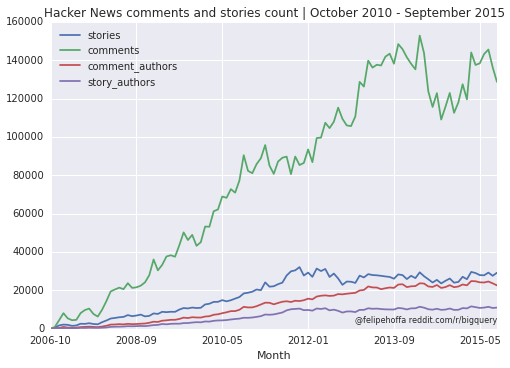

In [124]:
data=bq.Query(hn.counts).to_dataframe()[0:-1]
my_plot=data.set_index('month').plot(kind='line', title='Hacker News comments and stories count | October 2010 - September 2015')
my_plot.set_xlabel("Month")
import matplotlib.pyplot as plt
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')


Why is there a big drop on comments in 2014? I don't know, but I'd like to know. Also: Why did the growth of Hacker News stop? Number of stories and authors seems too stable for the last couple years.

In the meantime, let's jump to 2015 to see the average score of a story, depending on the hour it was posted. I'm in a GMT-7 timezone, but you can adapt the code to find the best time on your own timezone.

In [93]:
scores=bq.Query(hn.score_per_hour).to_dataframe()

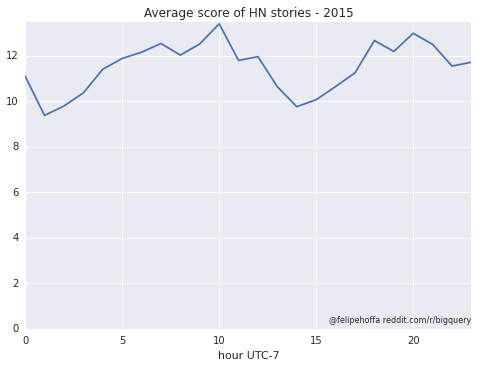

In [125]:
my_plot=scores.set_index('hour')['avg_score'].plot(kind='line', title='Average score of HN stories - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')



So there are 2 peaks for top stories: 10am and 8pm around the US Pacific Coast. 

But what if we want to get the best time to post a story? We have to consider how many are competing at the same time, and calculate a probability:

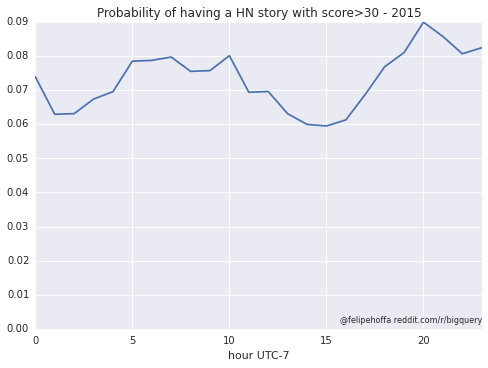

In [126]:
my_plot=scores.set_index('hour')['prob'].plot(kind='line', title='Probability of having a HN story with score>30 - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')


According to this chart, the best time to post a story is at 8pm Pacific.

Now let's see how many comments are posted by hour:


In [96]:

comments = bq.Query(hn.comments_per_hour).to_dataframe()

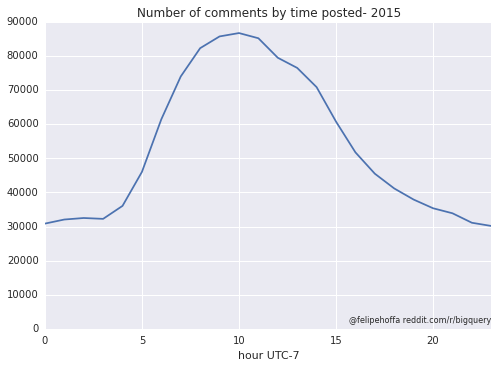

In [127]:
my_plot=comments.set_index('hour')['comments'].plot(kind='line', title='Number of comments by time posted- 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')


The peak is at 10AM Pacific. And what's the average ranking of these comments? (lower is better)

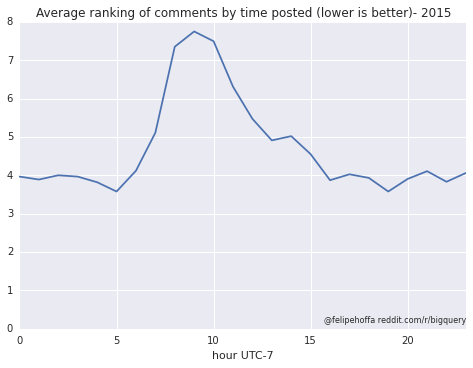

In [128]:
my_plot=comments.set_index('hour')['avg_ranking'].plot(kind='line', title='Average ranking of comments by time posted (lower is better)- 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')


So let's see the probability of having a top comment: The first comment of a story with a score>10:

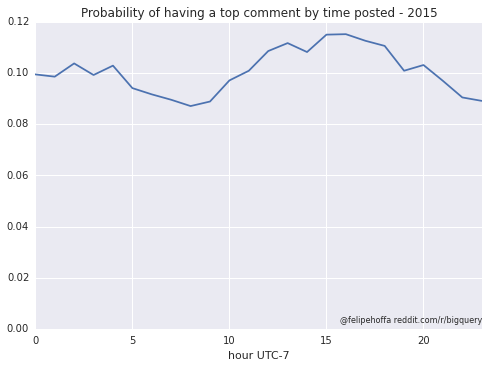

In [132]:
my_plot=bq.Query(hn.top_comments_per_hour).to_dataframe().set_index('hour')['prob'].plot(kind='line', title='Probability of having a top comment by time posted - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')


Time for you to play with this data!

The dataset is shared at https://bigquery.cloud.google.com/table/fh-bigquery:hackernews.comments.

Follow me on http://twitter.com/felipehoffa - and if you are new to BigQuery [get started with BigQuery in 5 minutes](https://www.reddit.com/r/bigquery/comments/3dg9le/analyzing_50_billion_wikipedia_pageviews_in_5/).





In [ ]:
"""
	Copyright 2015, Google, Inc.
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""